In [24]:
import xarray as xr
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pathlib import Path
from matplotlib.legend_handler import HandlerTuple
import matplotlib.lines as mlines
import matplotlib.ticker as ticker

sns.set_style("darkgrid")


# Define your parameters
encodings = ["pauli_encoding"]  # "enhanced_pauli_encoding"
ansatzes = ["BasicEntangling", "SimplifiedTwoDesign", "StronglyEntangling"]
costs = ["local", "global"]
n_qubits_range = range(2, 12 + 1)
n_circuit_layers_list = [1, 2, 3, 4]
n_layers_list = [1, 5, 10, 20]
file_types = ["abs_coeffs_var", "abs_coeffs_theory"]


def construct_path(
    encoding, ansatz, cost, n_qubits, n_circuit_layers, n_layers, file_type
):
    return f"../logs/{encoding}/{ansatz}_{cost}_qubits_{n_qubits:02}_circ_layers_{n_circuit_layers:02}_periodic_layers_{n_layers:02}/03000_samples/{file_type}.npy"


def load_and_pad_data(
    encoding,
    ansatz,
    cost,
    n_qubits,
    n_circuit_layers,
    n_layers,
    file_type,
    max_length,
):
    path = Path(
        construct_path(
            encoding,
            ansatz,
            cost,
            n_qubits,
            n_circuit_layers,
            n_layers,
            file_type,
        )
    )
    if path.exists():
        data = np.load(path)
        padded_data = np.pad(
            data, (0, max_length - len(data)), mode="constant", constant_values=np.nan
        )
        return padded_data
    else:
        return np.full(
            max_length, np.nan
        )  # Return an array of NaNs if the file does not exist


# Determine the maximum length of the arrays
max_length = 0
for combination in itertools.product(
    encodings,
    ansatzes,
    costs,
    n_qubits_range,
    n_circuit_layers_list,
    n_layers_list,
    file_types,
):
    path = Path(construct_path(*combination[:-1], combination[-1]))
    if path.exists():
        data = np.load(path)
        max_length = max(max_length, len(data))

# Create two dictionaries for storing padded data for each file type
padded_data_avg_dict = {}
padded_data_theory_dict = {}

# Iterate through combinations and file types
for combination in itertools.product(
    encodings,
    ansatzes,
    costs,
    n_qubits_range,
    n_circuit_layers_list,
    n_layers_list,
    file_types,
):
    padded_data = load_and_pad_data(*combination[:-1], combination[-1], max_length)
    if combination[-1] == "abs_coeffs_var":
        padded_data_avg_dict[combination[:-1]] = padded_data
    else:
        padded_data_theory_dict[combination[:-1]] = padded_data

# freqs range from 0 to max_freq - 1
freqs = np.arange(max_length)

# Create an empty Dataset with defined dimensions
coords = {
    "encoding": encodings,
    "ansatz": ansatzes,
    "cost": costs,
    "n_qubits": list(n_qubits_range),
    "n_circuit_layers": n_circuit_layers_list,
    "n_layers": n_layers_list,
    "freqs": freqs,
}

# Initialize the dataset with NaNs
shape = (
    len(encodings),
    len(ansatzes),
    len(costs),
    len(n_qubits_range),
    len(n_circuit_layers_list),
    len(n_layers_list),
    len(freqs),
)
initial_data = np.full(shape, np.nan)

# Initialize the dataset
var_dataset = xr.Dataset()

# Create DataArrays for each type of data and add them to the dataset
var_dataset["var_coeff"] = xr.DataArray(
    np.full(shape, np.nan), coords=coords, dims=list(coords.keys())
)
var_dataset["var_coeff_theory"] = xr.DataArray(
    np.full(shape, np.nan), coords=coords, dims=list(coords.keys())
)

# Populate the DataArrays with the padded data
for combination in itertools.product(
    encodings,
    ansatzes,
    costs,
    n_qubits_range,
    n_circuit_layers_list,
    n_layers_list,
):
    var_dataset["var_coeff"].loc[dict(zip(list(coords.keys())[:-1], combination))] = (
        padded_data_avg_dict.get(combination, np.full(max_length, np.nan))
    )
    var_dataset["var_coeff_theory"].loc[
        dict(zip(list(coords.keys())[:-1], combination))
    ] = padded_data_theory_dict.get(combination, np.full(max_length, np.nan))

# Display the dataset
var_dataset

<xarray.Dataset>
Dimensions:           (encoding: 1, ansatz: 3, cost: 2, n_qubits: 11,
                       n_circuit_layers: 4, n_layers: 4, freqs: 16)
Coordinates:
  * encoding          (encoding) <U14 'pauli_encoding'
  * ansatz            (ansatz) <U19 'BasicEntangling' ... 'StronglyEntangling'
  * cost              (cost) <U6 'local' 'global'
  * n_qubits          (n_qubits) int64 2 3 4 5 6 7 8 9 10 11 12
  * n_circuit_layers  (n_circuit_layers) int64 1 2 3 4
  * n_layers          (n_layers) int64 1 5 10 20
  * freqs             (freqs) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
Data variables:
    var_coeff         (encoding, ansatz, cost, n_qubits, n_circuit_layers, n_layers, freqs) float64 ...
    var_coeff_theory  (encoding, ansatz, cost, n_qubits, n_circuit_layers, n_layers, freqs) float64 ...

In [25]:
# Your existing setup
plotting_ansatz = "SimplifiedTwoDesign"
plotting_n_layers = 20

# Define color map based on the ansatz
if plotting_ansatz == "StronglyEntangling":
    colors = sns.color_palette("mako", n_colors=14)
elif plotting_ansatz == "SimplifiedTwoDesign":
    colors = sns.color_palette("rocket", n_colors=15)
else:
    colors = sns.color_palette("YlOrBr_r", n_colors=100)

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), sharey=True)

# Plot settings
plot_settings = {"marker": "o", "linewidth": 1.5, "markersize": 6, "zorder": 3}

# Initialize a list to hold custom legend entries
legend_entries = []

# Empty legend entry for subtitles
empty_handle = mlines.Line2D([], [], color="none", marker="none", linestyle="none")

# Add subtitle entries at the beginning
legend_entries.append((empty_handle, empty_handle))  # Empty space
legend_entries.append((empty_handle, empty_handle))  # Subtitles

# Plotting data
for freq, color in zip(range(0, 13), colors):
    # Plotting for "local" cost
    data_array = var_dataset["var_coeff"].sel(
        encoding="pauli_encoding",
        ansatz=plotting_ansatz,
        freqs=freq,
        n_circuit_layers=1,
        n_layers=plotting_n_layers,
        cost="local",
    )
    theory_array = var_dataset["var_coeff_theory"].sel(
        encoding="pauli_encoding",
        ansatz=plotting_ansatz,
        freqs=freq,
        n_circuit_layers=1,
        n_layers=plotting_n_layers,
        cost="local",
    )

    ax1.plot(
        data_array["n_qubits"],
        data_array,
        color=color,
        mec=mcolors.to_rgba(color, alpha=1),
        mfc=mcolors.to_rgba(color, alpha=0.5),
        **plot_settings,
    )
    ax1.plot(
        theory_array["n_qubits"],
        theory_array,
        color=color,
        marker="s",
        linestyle="",
        markersize=10,
        markerfacecolor="none",
    )

    # Plotting for "global" cost
    data_array = var_dataset["var_coeff"].sel(
        encoding="pauli_encoding",
        ansatz=plotting_ansatz,
        freqs=freq,
        n_circuit_layers=1,
        n_layers=plotting_n_layers,
        cost="global",
    )
    theory_array = var_dataset["var_coeff_theory"].sel(
        encoding="pauli_encoding",
        ansatz=plotting_ansatz,
        freqs=freq,
        n_circuit_layers=1,
        n_layers=plotting_n_layers,
        cost="global",
    )

    ax2.plot(
        data_array["n_qubits"],
        data_array,
        color=color,
        mec=mcolors.to_rgba(color, alpha=1),
        mfc=mcolors.to_rgba(color, alpha=0.5),
        **plot_settings,
    )
    ax2.plot(
        theory_array["n_qubits"],
        theory_array,
        color=color,
        marker="s",
        linestyle="",
        markersize=2,
        markerfacecolor="none",
    )

    # Create custom legend entries
    line_sample = mlines.Line2D(
        [],
        [],
        color="#000000",
        mec=mcolors.to_rgba("#000000", alpha=1),
        mfc=mcolors.to_rgba(color, alpha=0.5),
        marker="o",
        linestyle="-",
        linewidth=1.5,
        markersize=6,
    )
    line_theory = mlines.Line2D(
        [],
        [],
        color="#000000",
        marker="s",
        linestyle="",
        markersize=10,
        markerfacecolor="none",
    )

    # Pair the entries for the legend
    legend_entries.append((line_sample, line_theory))

# Axis labels and settings
ax1.set_xlabel("Number of Qubits", fontsize=20)
ax1.set_ylabel(r"Var[$c_\omega$]", fontsize=20)
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.tick_params(axis="both", which="major", labelsize=18)
ax2.set_xlabel("Number of Qubits", fontsize=20)
ax2.tick_params(axis="both", which="major", labelsize=18)

# Create and set the custom legend
legend = fig.legend(
    [entry for entry in legend_entries],
    [f"{freq} Sampling & 2-Design Theory" for freq in range(1, 13)],
    handler_map={tuple: HandlerTuple(ndivide=None)},
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    title_fontsize=20,
    fontsize=18,
    ncol=1,
)

# Adjust layout
plt.tight_layout()

# Show the

Error in callback <function _draw_all_if_interactive at 0x1521f5da0> (for post_execute):


RuntimeError: latex was not able to process the following string:
b'1 Sampling & 2-Design Theory'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error ../f4b6899cbf1e74a2b2abd13ff9c63abf.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../f4b6899cbf1e74a2b2abd13ff9c63abf.tex
LaTeX2e <2023-11-01> patch level 1
L3 programming layer <2024-01-22>
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/article.cls
Document Class: article 2023/05/17 v1.4n Standard LaTeX document class
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2023/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2023/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2023/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2023/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/local/texlive/2023/texmf-dist/tex/latex/amsmath/amsmath.sty
For additional information on amsmath, use the `?' option.
(/usr/local/texlive/2023/texmf-dist/tex/latex/amsmath/amstext.sty
(/usr/local/texlive/2023/texmf-dist/tex/latex/amsmath/amsgen.sty))
(/usr/local/texlive/2023/texmf-dist/tex/latex/amsmath/amsbsy.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/amsmath/amsopn.sty))
(/usr/local/texlive/2023/texmf-dist/tex/latex/doublestroke/dsfont.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/firstaid/underscore-ltx.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file f4b6899cbf1e74a2b2abd13ff9c63abf.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Misplaced alignment tab character &.
l.30 {\sffamily 1 Sampling &
                             2-Design Theory}%
No pages of output.
Transcript written on f4b6899cbf1e74a2b2abd13ff9c63abf.log.




RuntimeError: latex was not able to process the following string:
b'1 Sampling & 2-Design Theory'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error ../f4b6899cbf1e74a2b2abd13ff9c63abf.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(../f4b6899cbf1e74a2b2abd13ff9c63abf.tex
LaTeX2e <2023-11-01> patch level 1
L3 programming layer <2024-01-22>
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/article.cls
Document Class: article 2023/05/17 v1.4n Standard LaTeX document class
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2023/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2023/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2023/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2023/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/local/texlive/2023/texmf-dist/tex/latex/amsmath/amsmath.sty
For additional information on amsmath, use the `?' option.
(/usr/local/texlive/2023/texmf-dist/tex/latex/amsmath/amstext.sty
(/usr/local/texlive/2023/texmf-dist/tex/latex/amsmath/amsgen.sty))
(/usr/local/texlive/2023/texmf-dist/tex/latex/amsmath/amsbsy.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/amsmath/amsopn.sty))
(/usr/local/texlive/2023/texmf-dist/tex/latex/doublestroke/dsfont.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/firstaid/underscore-ltx.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file f4b6899cbf1e74a2b2abd13ff9c63abf.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Misplaced alignment tab character &.
l.30 {\sffamily 1 Sampling &
                             2-Design Theory}%
No pages of output.
Transcript written on f4b6899cbf1e74a2b2abd13ff9c63abf.log.




<Figure size 2000x500 with 2 Axes>

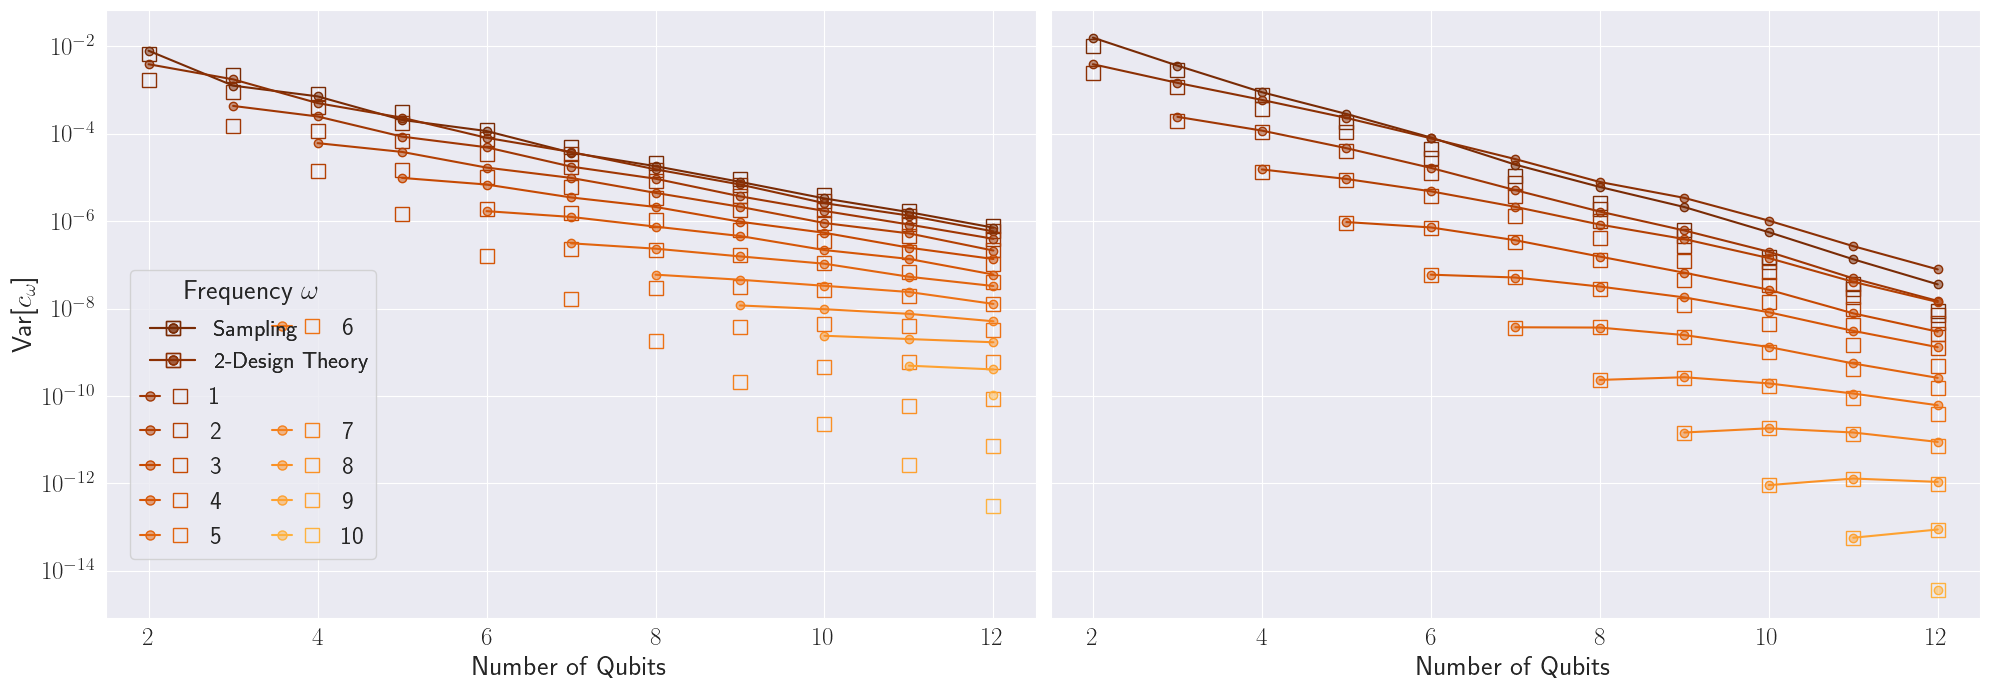

In [26]:
plotting_ansatz = "BasicEntangling"

plotting_n_layers = 1
# Set the style
sns.set_style("darkgrid")

# Define color map from blue to yellow using the "mako" color palette
if plotting_ansatz == "StronglyEntangling":
    colors = sns.color_palette("mako", n_colors=14)
elif plotting_ansatz == "SimplifiedTwoDesign":
    colors = sns.color_palette("rocket", n_colors=15)
else:
    colors = sns.color_palette("YlOrBr_r", n_colors=20)

# Create the figure and subplots that share the y-axis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7), sharey=True)

# Initialize an empty list to hold the legend handles
legend_entries = []
unique_sample = mlines.Line2D(
    [],
    [],
    color="k",
    mec=mcolors.to_rgba("k", alpha=1),
    mfc=mcolors.to_rgba("k", alpha=0.5),
    marker="o",
    linestyle="-",
    linewidth=1.5,
    markersize=6.5,
)
unique_theory = mlines.Line2D(
    [], [], color="k", marker="s", linestyle="", markersize=10, markerfacecolor="none"
)
legend_entries.append(unique_sample)
legend_entries.append(unique_theory)

# Plot settings that will be reused
plot_settings = {"marker": "o", "linewidth": 1.5, "markersize": 6, "zorder": 3}
legend_entries = []
legend_handles = []
square_handles = []

# Loop over each frequency for the "local" cost
for freq, color in zip(range(1, 13), colors):
    data_array = var_dataset["var_coeff"].sel(
        encoding="pauli_encoding",
        ansatz=plotting_ansatz,
        freqs=freq,
        n_circuit_layers=1,
        n_layers=plotting_n_layers,
        cost="local",
    )
    theory_array = var_dataset["var_coeff_theory"].sel(
        encoding="pauli_encoding",
        ansatz=plotting_ansatz,
        freqs=freq,
        n_circuit_layers=1,
        n_layers=plotting_n_layers,
        cost="local",
    )

    lines = ax1.plot(
        data_array["n_qubits"],
        data_array,
        color=color,
        mec=mcolors.to_rgba(color, alpha=1),
        mfc=mcolors.to_rgba(color, alpha=0.5),
        label=str(freq),
        **plot_settings
    )
    legend_handles.append(lines[0])  # Append the line handle to the legend handles list
    squares = ax1.plot(
        theory_array["n_qubits"],
        theory_array,
        color=color,
        marker="s",
        linestyle="",
        markersize=10,
        markerfacecolor="none",
    )
    square_handles.append(
        squares[0]
    )  # Append the square handle to the legend handles list
# Loop over each frequency for the "global" cost
for freq, color in zip(range(1, 13), colors):
    data_array = var_dataset["var_coeff"].sel(
        encoding="pauli_encoding",
        ansatz=plotting_ansatz,
        freqs=freq,
        n_circuit_layers=1,
        n_layers=plotting_n_layers,
        cost="global",
    )
    theory_array = var_dataset["var_coeff_theory"].sel(
        encoding="pauli_encoding",
        ansatz=plotting_ansatz,
        freqs=freq,
        n_circuit_layers=1,
        n_layers=plotting_n_layers,
        cost="global",
    )

    ax2.plot(
        data_array["n_qubits"],
        data_array,
        color=color,
        mec=mcolors.to_rgba(color, alpha=1),
        mfc=mcolors.to_rgba(color, alpha=0.5),
        **plot_settings
    )
    ax2.plot(
        theory_array["n_qubits"],
        theory_array,
        color=color,
        marker="s",
        linestyle="",
        markersize=10,
        markerfacecolor="none",
    )

    line_sample = mlines.Line2D(
        [],
        [],
        color=color,
        mec=mcolors.to_rgba(color, alpha=1),
        mfc=mcolors.to_rgba(color, alpha=0.5),
        marker="o",
        linestyle="-",
        linewidth=1.5,
        markersize=6.5,
    )
    line_theory = mlines.Line2D(
        [],
        [],
        color=color,
        marker="s",
        linestyle="",
        markersize=10,
        markerfacecolor="none",
    )
    # Pair the entries for the legend
    legend_entries.append((line_sample, line_theory))

# Set labels and legend for the first subplot
ax1.set_xlabel("Number of Qubits", fontsize=20)
ax1.set_ylabel(r"Var[$c_\omega$]", fontsize=20)
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.tick_params(axis="both", which="major", labelsize=18)

# Set labels for the second subplot
ax2.set_xlabel("Number of Qubits", fontsize=20)
ax2.tick_params(axis="both", which="major", labelsize=18)


# Set a common legend for the subplots
x_legend_loc, y_legend_loc = 0.1965, 0.625
first_legend_labels = ["Sampling", "2-Design Theory"]
first_legend = fig.legend(
    [entry for entry in legend_entries[:2]],
    first_legend_labels,
    bbox_to_anchor=(x_legend_loc, y_legend_loc - 0.06),
    title_fontsize=20,
    fontsize=16.5,
    ncols=1,
    frameon=False,
)

# Add the first legend manually to the plot
empty_handle = mlines.Line2D([], [], color="none", marker="none", linestyle="none")
fig.add_artist(first_legend)
handles = (
    [empty_handle, empty_handle]
    + [entry for entry in legend_entries[2:8]]
    + [empty_handle, empty_handle]
    + [entry for entry in legend_entries[8:]]
)
legend_labels = (
    ["", ""]
    + [str(freq) for freq in range(1, 7)]
    + ["", ""]
    + [str(freq) for freq in range(7, 13)]
)
legend = fig.legend(
    handles,
    legend_labels,
    title=r"Frequency $\omega$",
    bbox_to_anchor=(x_legend_loc, y_legend_loc),
    handler_map={tuple: HandlerTuple(None)},
    title_fontsize=20,
    fontsize=18,
    ncols=2,
)
first_legend.set_zorder(3)
legend.set_zorder(2)
# Adjust the layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

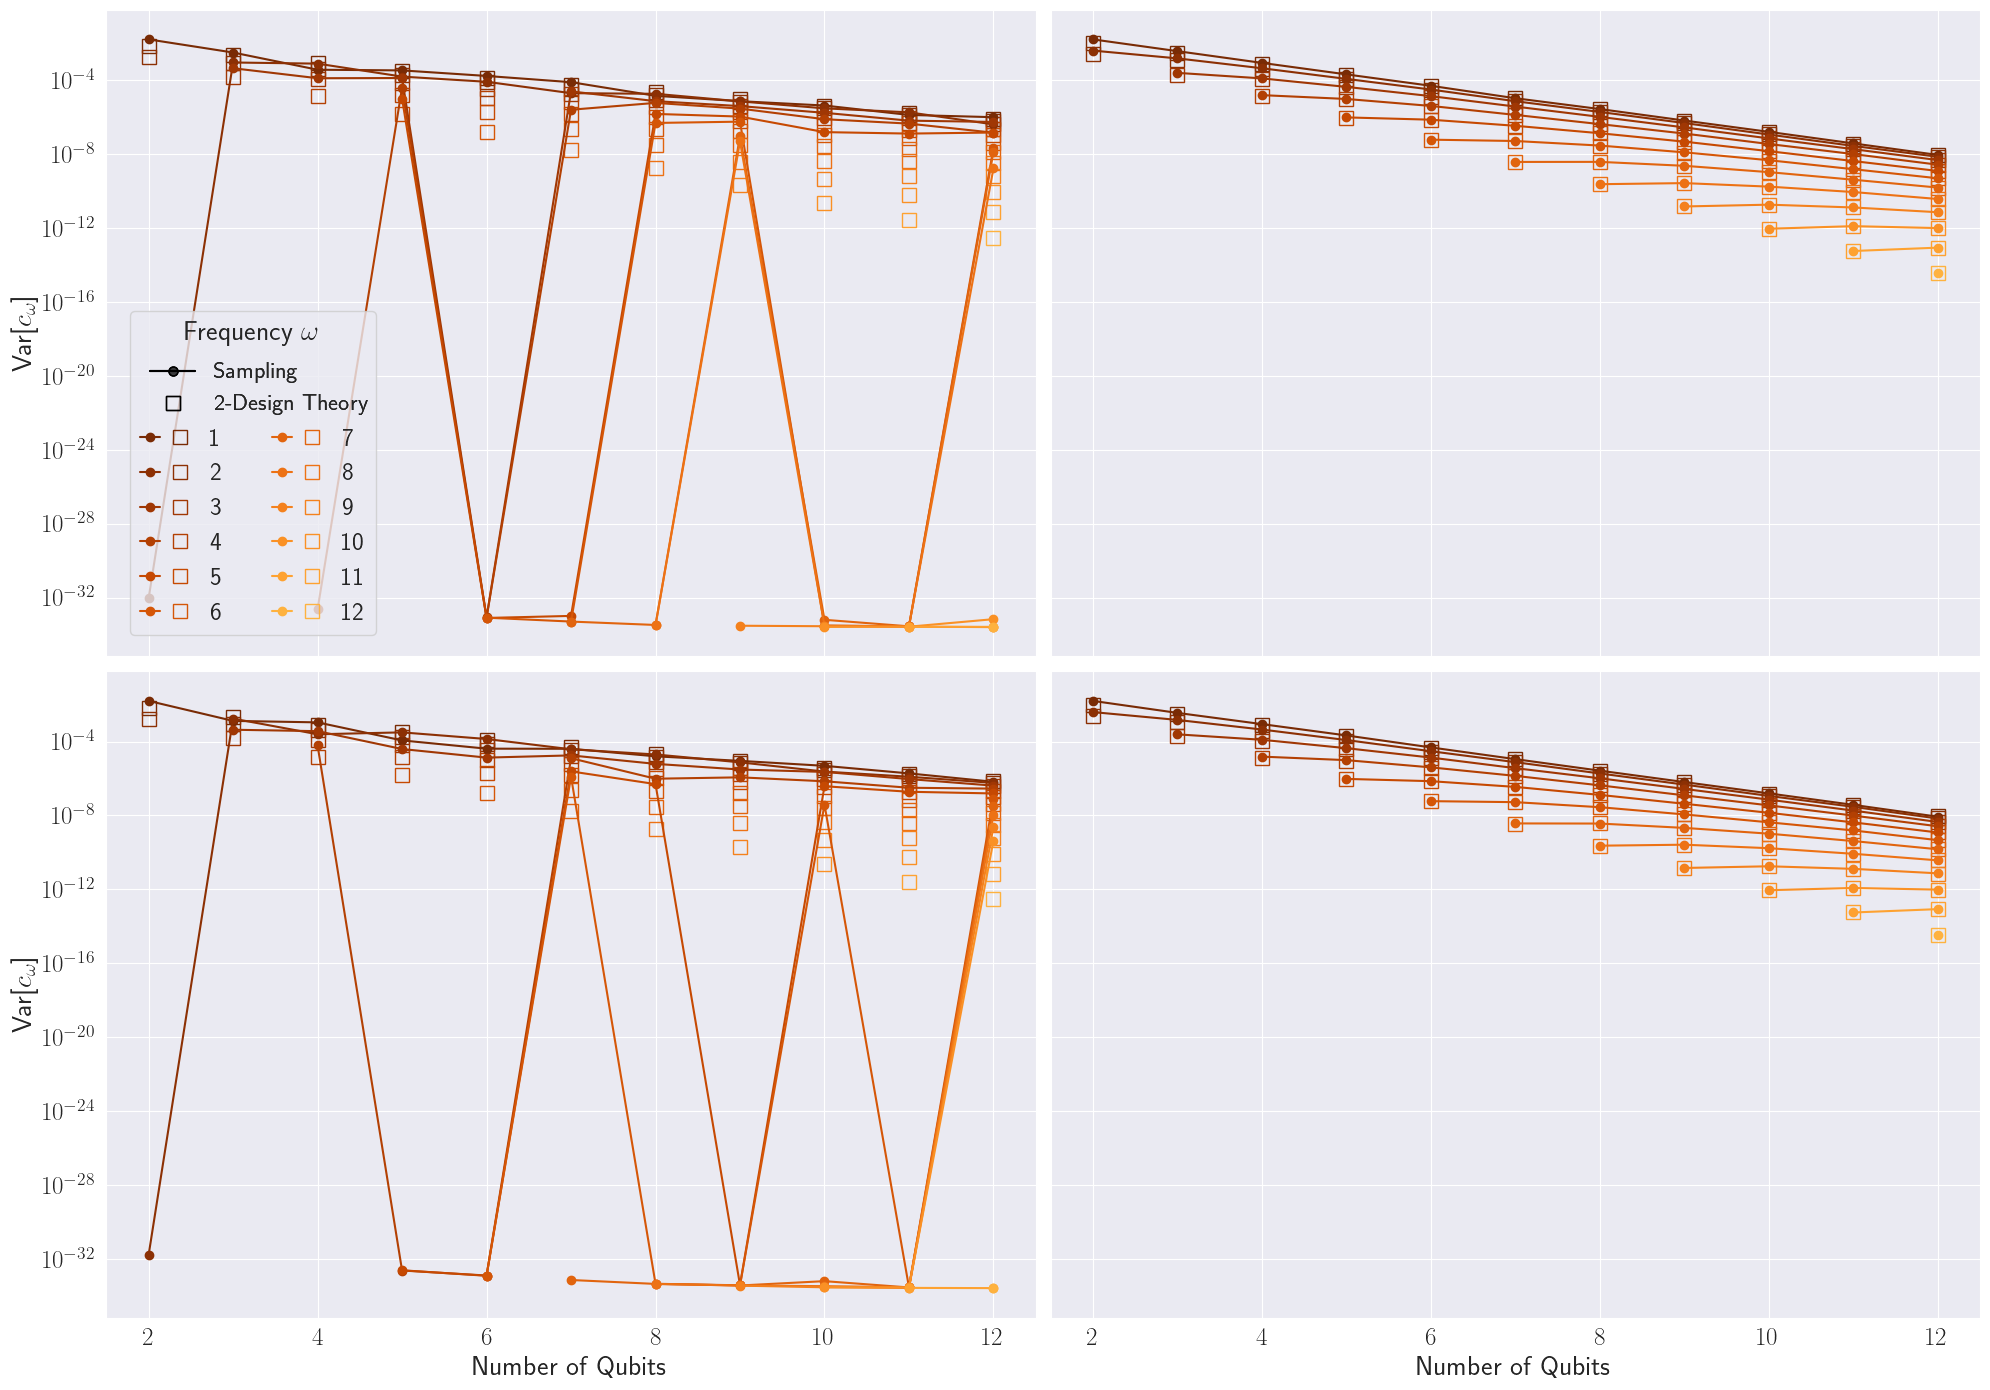

In [27]:
plotting_ansatz = "BasicEntangling"

# Define color map based on the ansatz
if plotting_ansatz == "StronglyEntangling":
    colors = sns.color_palette("mako", n_colors=14)
elif plotting_ansatz == "SimplifiedTwoDesign":
    colors = sns.color_palette("rocket", n_colors=15)
else:
    colors = sns.color_palette("YlOrBr_r", n_colors=20)

# Create a 2x2 subplot grid, sharing the x-axis across rows
fig, axs = plt.subplots(2, 2, figsize=(20, 14), sharex=True, sharey=True)

# Initialize empty lists for legend handles
legend_entries = []
legend_handles = []
square_handles = []
unique_sample = mlines.Line2D(
    [],
    [],
    color="k",
    mec=mcolors.to_rgba("k", alpha=1),
    mfc=mcolors.to_rgba("k", alpha=0.5),
    marker="o",
    linestyle="-",
    linewidth=1.5,
    markersize=6.5,
)
unique_theory = mlines.Line2D(
    [], [], color="k", marker="s", linestyle="", markersize=10, markerfacecolor="none"
)
legend_entries.append(unique_sample)
legend_entries.append(unique_theory)

# Plot settings
plot_settings = {"marker": "o", "linewidth": 1.5, "markersize": 6, "zorder": 3}

# Define the range of frequencies to plot
frequency_range = range(1, 13)

# Initialize variables to determine common ylim
min_y, max_y = float("inf"), float("-inf")

# Loop for plotting; iterate over rows (layer numbers) and columns (cost types)
for row, plotting_n_layers in enumerate([10, 20]):
    for col, cost_type in enumerate(["local", "global"]):
        ax = axs[row, col]
        for freq, color in zip(frequency_range, colors):
            # Select the appropriate data based on layer number and cost type
            data_array = var_dataset["var_coeff"].sel(
                encoding="pauli_encoding",
                ansatz=plotting_ansatz,
                freqs=freq,
                n_circuit_layers=1,
                n_layers=plotting_n_layers,
                cost=cost_type,
            )
            theory_array = var_dataset["var_coeff_theory"].sel(
                encoding="pauli_encoding",
                ansatz=plotting_ansatz,
                freqs=freq,
                n_circuit_layers=1,
                n_layers=plotting_n_layers,
                cost=cost_type,
            )

            # Plot the data and theory arrays
            lines = ax.plot(
                data_array["n_qubits"], data_array, color=color, **plot_settings
            )
            ax.plot(
                theory_array["n_qubits"],
                theory_array,
                color=color,
                marker="s",
                linestyle="",
                markersize=10,
                markerfacecolor="none",
            )

            # Add legend entries only for the first row and column
            if row == 0 and col == 0:
                legend_handles.append(lines[0])
                square_handles.append(
                    mlines.Line2D(
                        [],
                        [],
                        color=color,
                        marker="s",
                        linestyle="",
                        markersize=10,
                        markerfacecolor="none",
                    )
                )
                line_sample = mlines.Line2D([], [], color=color, **plot_settings)
                legend_entries.append((line_sample, square_handles[-1]))

        # Set axis labels and scale

        ax.set_yscale("log")
        min_y = min(min_y, ax.get_ylim()[0])
        max_y = max(max_y, ax.get_ylim()[1])
        ax.tick_params(axis="both", which="major", labelsize=18)
        if col == 0:
            ax.set_ylabel(r"Var[$c_\omega$]", fontsize=20)
        if row == 1:  # Set x-axis labels only for the bottom row
            ax.set_xlabel("Number of Qubits", fontsize=20)

# Set the same ylim for all subplots
for ax in axs.flat:
    ax.set_ylim(min_y, max_y)

# Set legends
x_legend_loc, y_legend_loc = 0.1965, 0.783
first_legend_labels = ["Sampling", "2-Design Theory"]
first_legend = fig.legend(
    [entry for entry in legend_entries[:2]],
    first_legend_labels,
    bbox_to_anchor=(x_legend_loc, y_legend_loc - 0.031),
    title_fontsize=20,
    fontsize=16.5,
    ncols=1,
    frameon=False,
)

# Add the first legend manually to the plot
empty_handle = mlines.Line2D([], [], color="none", marker="none", linestyle="none")
fig.add_artist(first_legend)
handles = (
    [empty_handle, empty_handle]
    + [entry for entry in legend_entries[2:8]]
    + [empty_handle, empty_handle]
    + [entry for entry in legend_entries[8:]]
)
legend_labels = (
    ["", ""]
    + [str(freq) for freq in range(1, 7)]
    + ["", ""]
    + [str(freq) for freq in range(7, 13)]
)
legend = fig.legend(
    handles,
    legend_labels,
    title=r"Frequency $\omega$",
    bbox_to_anchor=(x_legend_loc, y_legend_loc),
    handler_map={tuple: HandlerTuple(None)},
    title_fontsize=20,
    fontsize=18,
    ncols=2,
)
first_legend.set_zorder(3)
legend.set_zorder(2)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

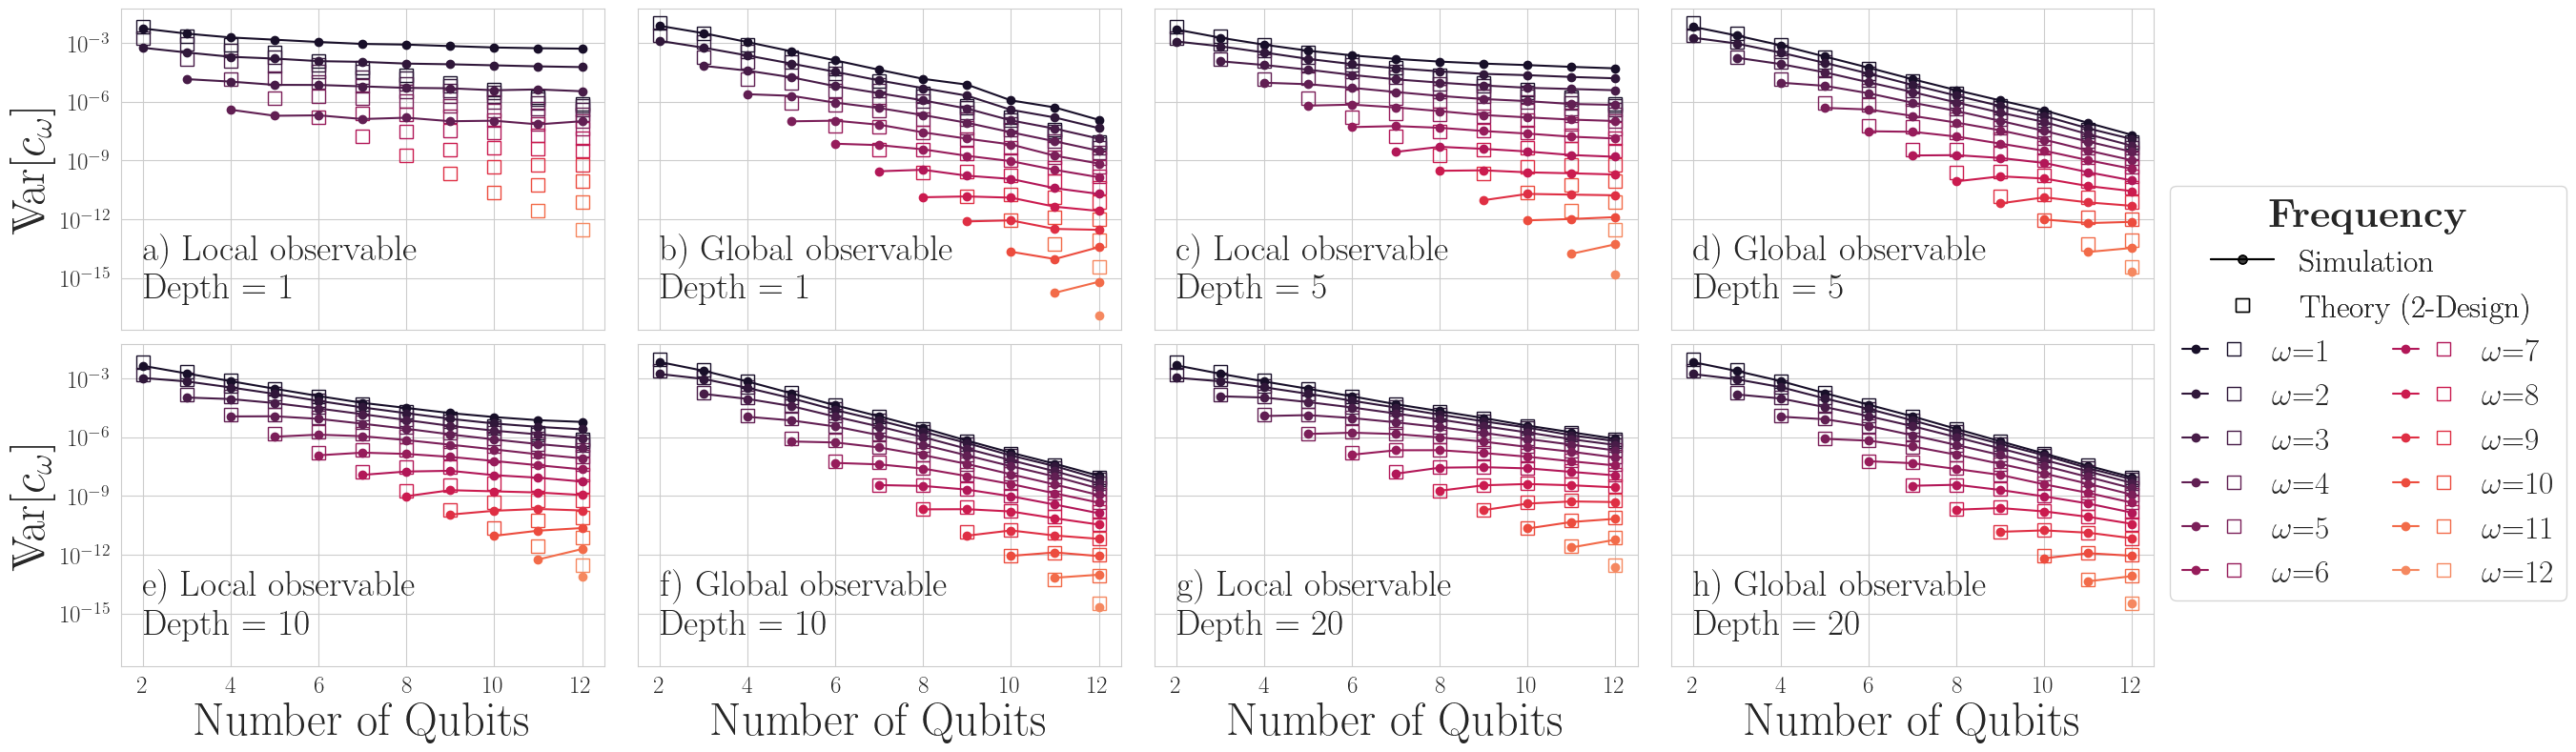

In [34]:
import matplotlib

# matplotlib.use("pgf")
sns.set_style("whitegrid")
matplotlib.rcParams.update(
    {
        "pgf.preamble": (
            r"\usepackage{amsmath} \usepackage{dsfont}  \newcommand{\Var}{\operatorname{\mathds{V}\!ar}}"
        ),
        "pgf.texsystem": "pdflatex",
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
    }
)
matplotlib.rcParams["text.latex.preamble"] = (
    r"\usepackage{amsmath} \usepackage{dsfont}  \newcommand{\Var}{\operatorname{\mathds{V}\!ar}}"
)
plotting_ansatz = "SimplifiedTwoDesign"
ax_text = [
    "a) Local observable \n     Depth = 1",
    "b) Global observable \n    Depth =  1 ",
    "c) Local observable \n     Depth = 5",
    "d) Global observable \n     Depth = 5",
    "e) Local observable \n      Depth = 10",
    "f) Global observable \n      Depth = 10",
    "g) Local observable \n      Depth = 20",
    "h) Global observable \n      Depth = 20",
]
# Define color map based on the ansatz
if plotting_ansatz == "StronglyEntangling":
    colors = sns.color_palette("mako", n_colors=14)
elif plotting_ansatz == "SimplifiedTwoDesign":
    colors = sns.color_palette("rocket", n_colors=15)
else:
    colors = sns.color_palette("YlOrBr_r", n_colors=20)

# Create a 2x2 subplot grid, sharing the x-axis across rows
fig, axs = plt.subplots(2, 4, figsize=(23, 8), sharex=True, sharey=True)

# Initialize empty lists for legend handles
legend_entries = []
legend_handles = []
square_handles = []
unique_sample = mlines.Line2D(
    [],
    [],
    color="k",
    mec=mcolors.to_rgba("k", alpha=1),
    mfc=mcolors.to_rgba("k", alpha=0.5),
    marker="o",
    linestyle="-",
    linewidth=1.5,
    markersize=6.5,
)
unique_theory = mlines.Line2D(
    [], [], color="k", marker="s", linestyle="", markersize=10, markerfacecolor="none"
)
legend_entries.append(unique_sample)
legend_entries.append(unique_theory)

# Plot settings
plot_settings = {"marker": "o", "linewidth": 1.5, "markersize": 6, "zorder": 3}

# Define the range of frequencies to plot
frequency_range = range(1, 13)

# Initialize variables to determine common ylim
min_y, max_y = float("inf"), float("-inf")
i = -1
# Loop for plotting; iterate over rows (layer numbers) and columns (cost types)
for row, plotting_n_layers in enumerate([1, 5, 10, 20]):
    for col, cost_type in enumerate(["local", "global"]):
        ax = axs[row // 2, 2 * (row % 2) + col]
        i += 1
        for freq, color in zip(frequency_range, colors):
            # Select the appropriate data based on layer number and cost type
            data_array = var_dataset["var_coeff"].sel(
                encoding="pauli_encoding",
                ansatz=plotting_ansatz,
                freqs=freq,
                n_circuit_layers=1,
                n_layers=plotting_n_layers,
                cost=cost_type,
            )
            theory_array = var_dataset["var_coeff_theory"].sel(
                encoding="pauli_encoding",
                ansatz=plotting_ansatz,
                freqs=freq,
                n_circuit_layers=1,
                n_layers=plotting_n_layers,
                cost=cost_type,
            )

            # Plot the data and theory arrays
            # lines = ax.plot(data_array['n_qubits'], data_array, color=color, **plot_settings)
            # ax.plot(theory_array['n_qubits'], theory_array, color=color, marker='s', linestyle='', markersize=10, markerfacecolor='none')
            # Check if data is above threshold before plotting
            data_above_threshold = data_array.where(data_array > 1e-28, drop=True)
            theory_above_threshold = theory_array.where(theory_array > 1e-28, drop=True)

            if data_above_threshold.size > 0:
                ax.plot(
                    data_above_threshold["n_qubits"],
                    data_above_threshold,
                    color=color,
                    **plot_settings
                )
            if theory_above_threshold.size > 0:
                ax.plot(
                    theory_above_threshold["n_qubits"],
                    theory_above_threshold,
                    color=color,
                    marker="s",
                    linestyle="",
                    markersize=10,
                    markerfacecolor="none",
                )

            # Add legend entries only for the first row and column
            if row == 0 and col == 0:
                legend_handles.append(lines[0])
                square_handles.append(
                    mlines.Line2D(
                        [],
                        [],
                        color=color,
                        marker="s",
                        linestyle="",
                        markersize=10,
                        markerfacecolor="none",
                    )
                )
                line_sample = mlines.Line2D([], [], color=color, **plot_settings)
                legend_entries.append((line_sample, square_handles[-1]))

        # Set axis labels and scale
        if plotting_ansatz == "BasicEntangling":
            ax.text(2, 10**-14, ax_text[i], fontsize=27)
        else:
            ax.text(2, 10**-16, ax_text[i], fontsize=27)
        ax.set_yscale("log")
        ax.tick_params(axis="both", which="major", labelsize=18)
        min_y = min(min_y, ax.get_ylim()[0])
        max_y = max(max_y, ax.get_ylim()[1])
        ax.tick_params(axis="both", which="major", labelsize=18)
        if col == 0 and (row == 0 or row == 2):
            ax.set_ylabel(r"$\Var[c_\omega]$", fontsize=35)
        if row == 2 or row == 3:  # Set x-axis labels only for the bottom row
            ax.set_xlabel("Number of Qubits", fontsize=35)

# Set the same ylim for all subplots
for ax in axs.flat:
    ax.set_ylim(min_y, max_y)

# Set legends
x_legend_loc, y_legend_loc = 1.18, 0.77
first_legend_labels = ["Simulation", "Theory (2-Design) "]
first_legend = fig.legend(
    [entry for entry in legend_entries[:2]],
    first_legend_labels,
    bbox_to_anchor=(x_legend_loc - 0.01, y_legend_loc - 0.066),
    fontsize=24,
    ncols=1,
    frameon=False,
)

# Add the first legend manually to the plot
empty_handle = mlines.Line2D([], [], color="none", marker="none", linestyle="none")
fig.add_artist(first_legend)
handles = (
    [empty_handle, empty_handle]
    + [entry for entry in legend_entries[2:8]]
    + [empty_handle, empty_handle]
    + [entry for entry in legend_entries[8:]]
)
legend_labels = (
    ["", ""]
    + [r"$\omega$=" + str(freq) for freq in range(1, 7)]
    + ["", ""]
    + [r"$\omega$=" + str(freq) for freq in range(7, 13)]
)
legend = fig.legend(
    handles,
    legend_labels,
    title=r"\textbf{Frequency}",
    bbox_to_anchor=(x_legend_loc, y_legend_loc),
    handler_map={tuple: HandlerTuple(None)},
    title_fontsize=30,
    fontsize=24,
    ncols=2,
)

first_legend.set_zorder(3)
legend.set_zorder(2)

# Adjust the layout
plt.tight_layout()

plt.savefig("figs_numerics/"+plotting_ansatz + "_var_qubits.pgf", bbox_inches="tight")
# Show the plot
plt.show()

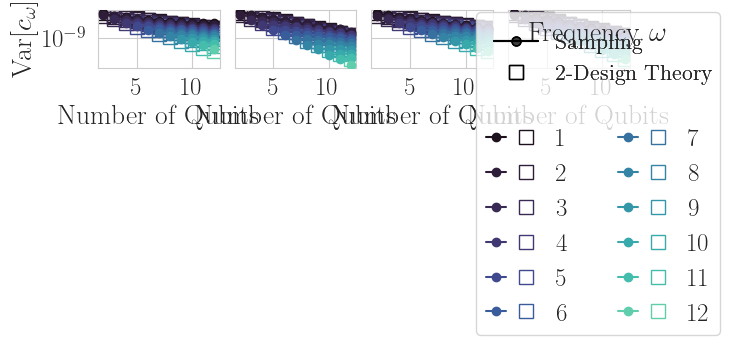

In [ ]:
import matplotlib

# matplotlib.use("png")
matplotlib.rcParams.update(
    {
        # "pgf.texsystem": "pdflatex",
        "font.family": "serif",
        #'text.usetex': True,
        #'pgf.rcfonts': False,
    }
)

plotting_ansatz = "StronglyEntangling"

# Define color map based on the ansatz
if plotting_ansatz == "StronglyEntangling":
    colors = sns.color_palette("mako", n_colors=14)
elif plotting_ansatz == "SimplifiedTwoDesign":
    colors = sns.color_palette("rocket", n_colors=15)
else:
    colors = sns.color_palette("YlOrBr_r", n_colors=20)

# Create a 2x2 subplot grid, sharing the x-axis across rows
fig, axs = plt.subplots(1, 4, figsize=(6.50127, 1.5), sharex=True, sharey=True)
# Flatten axs for easier indexing
axs = axs.flatten()

# Define the layers and cost types to plot
layers_list = [1, 5]
cost_types = ["local", "global"]
# Initialize empty lists for legend handles
legend_entries = []
legend_handles = []
square_handles = []
unique_sample = mlines.Line2D(
    [],
    [],
    color="k",
    mec=mcolors.to_rgba("k", alpha=1),
    mfc=mcolors.to_rgba("k", alpha=0.5),
    marker="o",
    linestyle="-",
    linewidth=1.5,
    markersize=6.5,
)
unique_theory = mlines.Line2D(
    [], [], color="k", marker="s", linestyle="", markersize=10, markerfacecolor="none"
)
legend_entries.append(unique_sample)
legend_entries.append(unique_theory)

# Plot settings
plot_settings = {"marker": "o", "linewidth": 1.5, "markersize": 6, "zorder": 3}

# Define the range of frequencies to plot
frequency_range = range(1, 13)

# Initialize variables to determine common ylim
min_y, max_y = float("inf"), float("-inf")

# Loop for plotting; iterate over rows (layer numbers) and columns (cost types)
for i, (plotting_n_layers, cost_type) in enumerate(
    itertools.product(layers_list, cost_types)
):
    ax = axs[i]
    for freq, color in zip(frequency_range, colors):
        # Select the appropriate data based on layer number and cost type
        data_array = var_dataset["var_coeff"].sel(
            encoding="pauli_encoding",
            ansatz=plotting_ansatz,
            freqs=freq,
            n_circuit_layers=1,
            n_layers=plotting_n_layers,
            cost=cost_type,
        )
        theory_array = var_dataset["var_coeff_theory"].sel(
            encoding="pauli_encoding",
            ansatz=plotting_ansatz,
            freqs=freq,
            n_circuit_layers=1,
            n_layers=plotting_n_layers,
            cost=cost_type,
        )

        # Plot the data and theory arrays
        # lines = ax.plot(data_array['n_qubits'], data_array, color=color, **plot_settings)
        # ax.plot(theory_array['n_qubits'], theory_array, color=color, marker='s', linestyle='', markersize=10, markerfacecolor='none')
        # Check if data is above threshold before plotting
        data_above_threshold = data_array.where(data_array > 1e-28, drop=True)
        theory_above_threshold = theory_array.where(theory_array > 1e-28, drop=True)

        if data_above_threshold.size > 0:
            ax.plot(
                data_above_threshold["n_qubits"],
                data_above_threshold,
                color=color,
                **plot_settings
            )
        if theory_above_threshold.size > 0:
            ax.plot(
                theory_above_threshold["n_qubits"],
                theory_above_threshold,
                color=color,
                marker="s",
                linestyle="",
                markersize=10,
                markerfacecolor="none",
            )

        # Add legend entries only for the first row and column
        if i == 0:
            legend_handles.append(lines[0])
            square_handles.append(
                mlines.Line2D(
                    [],
                    [],
                    color=color,
                    marker="s",
                    linestyle="",
                    markersize=10,
                    markerfacecolor="none",
                )
            )
            line_sample = mlines.Line2D([], [], color=color, **plot_settings)
            legend_entries.append((line_sample, square_handles[-1]))

    # Set axis labels and scale
    ax.set_yscale("log")
    ax.tick_params(axis="both", which="major", labelsize=18)
    min_y = min(min_y, ax.get_ylim()[0])
    max_y = max(max_y, ax.get_ylim()[1])
    ax.tick_params(axis="both", which="major", labelsize=18)
    if i == 0:
        ax.set_ylabel(r"Var[$c_\omega$]", fontsize=20)
    ax.set_xlabel("Number of Qubits", fontsize=20)

# Set the same ylim for all subplots
for ax in axs.flat:
    ax.set_ylim(min_y, max_y)

# Set legends
x_legend_loc, y_legend_loc = 1.135, 0.97
first_legend_labels = ["Sampling", "2-Design Theory"]
first_legend = fig.legend(
    [entry for entry in legend_entries[:2]],
    first_legend_labels,
    bbox_to_anchor=(x_legend_loc, y_legend_loc - 0.095),
    fontsize=16,
    ncols=1,
    frameon=False,
)

# Add the first legend manually to the plot
empty_handle = mlines.Line2D([], [], color="none", marker="none", linestyle="none")
fig.add_artist(first_legend)
handles = (
    [empty_handle, empty_handle]
    + [entry for entry in legend_entries[2:8]]
    + [empty_handle, empty_handle]
    + [entry for entry in legend_entries[8:]]
)
legend_labels = (
    ["", ""]
    + [str(freq) for freq in range(1, 7)]
    + ["", ""]
    + [str(freq) for freq in range(7, 13)]
)
legend = fig.legend(
    handles,
    legend_labels,
    title=r"Frequency $\omega$",
    bbox_to_anchor=(x_legend_loc, y_legend_loc),
    handler_map={tuple: HandlerTuple(None)},
    title_fontsize=20,
    fontsize=18,
    ncols=2,
)
first_legend.set_zorder(3)
legend.set_zorder(2)

# Adjust the layout
plt.tight_layout()
# plt.savefig('var_coeff.pgf',bbox_inches='tight')
# Show the plot
plt.show()

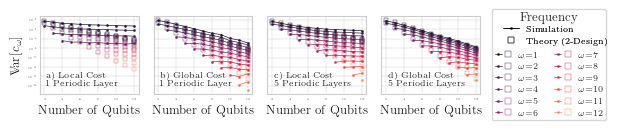

In [ ]:
import matplotlib

# matplotlib.use("pgf")
sns.set_style("whitegrid")
matplotlib.rcParams.update(
    {
        "pgf.preamble": (
            r"\usepackage{amsmath} \usepackage{dsfont}  \newcommand{\Var}{\operatorname{\mathds{V}\!ar}}"
        ),
        "pgf.texsystem": "pdflatex",
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
    }
)
matplotlib.rcParams["text.latex.preamble"] = (
    r"\usepackage{amsmath} \usepackage{dsfont}  \newcommand{\Var}{\operatorname{\mathds{V}\!ar}}"
)

tics_font = 2
smaller_font = 6
small_font = 9
big_font = 10
plotting_ansatz = "SimplifiedTwoDesign"

# Define color map based on the ansatz
if plotting_ansatz == "StronglyEntangling":
    colors = sns.color_palette("mako", n_colors=14)
elif plotting_ansatz == "SimplifiedTwoDesign":
    colors = sns.color_palette("rocket", n_colors=15)
else:
    colors = sns.color_palette("YlOrBr_r", n_colors=20)

# Create a 2x2 subplot grid, sharing the x-axis across rows
fig, axs = plt.subplots(1, 4, figsize=(5, 1.3), sharex=True, sharey=True)
# Flatten axs for easier indexing
axs = axs.flatten()

# Define the layers and cost types to plot
layers_list = [1, 5]
cost_types = ["local", "global"]
# Initialize empty lists for legend handles
legend_entries = []
legend_handles = []
square_handles = []
unique_sample = mlines.Line2D(
    [],
    [],
    color="k",
    mec=mcolors.to_rgba("k", alpha=0.5),
    mfc=mcolors.to_rgba("k", alpha=0.5),
    marker="o",
    linestyle="-",
    linewidth=0.5,
    markersize=1,
)
unique_theory = mlines.Line2D(
    [],
    [],
    color="k",
    marker="s",
    linestyle="",
    markersize=5,
    markerfacecolor="none",
    markeredgewidth=0.3,
)
legend_entries.append(unique_sample)
legend_entries.append(unique_theory)

# Plot settings
plot_settings = {"marker": "o", "linewidth": 0.5, "markersize": 1, "zorder": 3}

# Define the range of frequencies to plot
frequency_range = range(1, 13)

# Initialize variables to determine common ylim
min_y, max_y = float("inf"), float("-inf")
ax_text = [
    "a) Local Observable \n      1 Blocks per Layer",
    "b) Global Observable \n      1 Blocks per Layer",
    "c) Local Observable \n      5 Blocks per Layer",
    "d) Global Observable \n      5 Blocks per Layer",
]
# Loop for plotting; iterate over rows (layer numbers) and columns (cost types)
for i, (plotting_n_layers, cost_type) in enumerate(
    itertools.product(layers_list, cost_types)
):
    ax = axs[i]
    for freq, color in zip(frequency_range, colors):
        # Select the appropriate data based on layer number and cost type
        data_array = var_dataset["var_coeff"].sel(
            encoding="pauli_encoding",
            ansatz=plotting_ansatz,
            freqs=freq,
            n_circuit_layers=1,
            n_layers=plotting_n_layers,
            cost=cost_type,
        )
        theory_array = var_dataset["var_coeff_theory"].sel(
            encoding="pauli_encoding",
            ansatz=plotting_ansatz,
            freqs=freq,
            n_circuit_layers=1,
            n_layers=plotting_n_layers,
            cost=cost_type,
        )

        # Plot the data and theory arrays
        # lines = ax.plot(data_array['n_qubits'], data_array, color=color, **plot_settings)
        # ax.plot(theory_array['n_qubits'], theory_array, color=color, marker='s', linestyle='', markersize=10, markerfacecolor='none')
        # Check if data is above threshold before plotting
        data_above_threshold = data_array.where(data_array > 1e-28, drop=True)
        theory_above_threshold = theory_array.where(theory_array > 1e-28, drop=True)

        if data_above_threshold.size > 0:
            ax.plot(
                data_above_threshold["n_qubits"],
                data_above_threshold,
                color=color,
                mfc=mcolors.to_rgba(color, alpha=0.8),
                **plot_settings
            )
        if theory_above_threshold.size > 0:
            ax.plot(
                theory_above_threshold["n_qubits"],
                theory_above_threshold,
                color=color,
                marker="s",
                markeredgewidth=0.3,
                linestyle="",
                markersize=3,
                markerfacecolor="none",
            )

        # Add legend entries only for the first row and column
        if i == 0:
            legend_handles.append(lines[0])
            square_handles.append(
                mlines.Line2D(
                    [],
                    [],
                    color=color,
                    marker="s",
                    linestyle="",
                    markeredgewidth=0.3,
                    markersize=5,
                    markerfacecolor="none",
                )
            )
            line_sample = mlines.Line2D(
                [],
                [],
                color=color,
                mfc=mcolors.to_rgba(color, alpha=0.8),
                **plot_settings
            )
            legend_entries.append((line_sample, square_handles[-1]))

    # Set axis labels and scale
    ax.set_yscale("log")
    ax.grid(linewidth=0.3)
    ax.tick_params(axis="both", which="major", labelsize=tics_font)
    min_y = min(min_y, ax.get_ylim()[0])
    max_y = max(max_y, ax.get_ylim()[1])
    ax.tick_params(axis="both", which="major", labelsize=tics_font, pad=-1)
    ax.text(2.2, 10**-16, ax_text[i], fontsize=smaller_font)

    if i == 0:
        ax.set_ylabel(r"$\Var[c_\omega]$", fontsize=small_font)
    ax.set_xlabel("Number of Qubits", fontsize=small_font)

# Set the same ylim for all subplots
for ax in axs.flat:
    ax.set_ylim(min_y, max_y)

# Set legends
x_legend_loc, y_legend_loc = 1.23, 0.97
first_legend_labels = ["Simulation", "Theory (2-Design)"]
first_legend = fig.legend(
    [entry for entry in legend_entries[:2]],
    first_legend_labels,
    bbox_to_anchor=(x_legend_loc + 0.01, y_legend_loc - 0.095),
    fontsize=smaller_font,
    ncols=1,
    frameon=False,
)

# Add the first legend manually to the plot
empty_handle = mlines.Line2D([], [], color="none", marker="none", linestyle="none")
fig.add_artist(first_legend)
handles = (
    [empty_handle, empty_handle]
    + [entry for entry in legend_entries[2:8]]
    + [empty_handle, empty_handle]
    + [entry for entry in legend_entries[8:]]
)
legend_labels = (
    ["", ""]
    + [r"$\omega$=" + str(freq) for freq in range(1, 7)]
    + ["", ""]
    + [r"$\omega$=" + str(freq) for freq in range(7, 13)]
)
legend = fig.legend(
    handles,
    legend_labels,
    title=r"Frequency",
    bbox_to_anchor=(x_legend_loc, y_legend_loc),
    handler_map={tuple: HandlerTuple(None)},
    title_fontsize=small_font,
    fontsize=smaller_font,
    ncols=2,
)
first_legend.set_zorder(3)
legend.set_zorder(2)

# Adjust the layout
plt.tight_layout()
plt.savefig("figs_numerics/figApp_2.pgf", bbox_inches="tight")
# plt.savefig('../Figures/var_coeff.pgf',bbox_inches='tight')
# Show the plot
# plt.show()

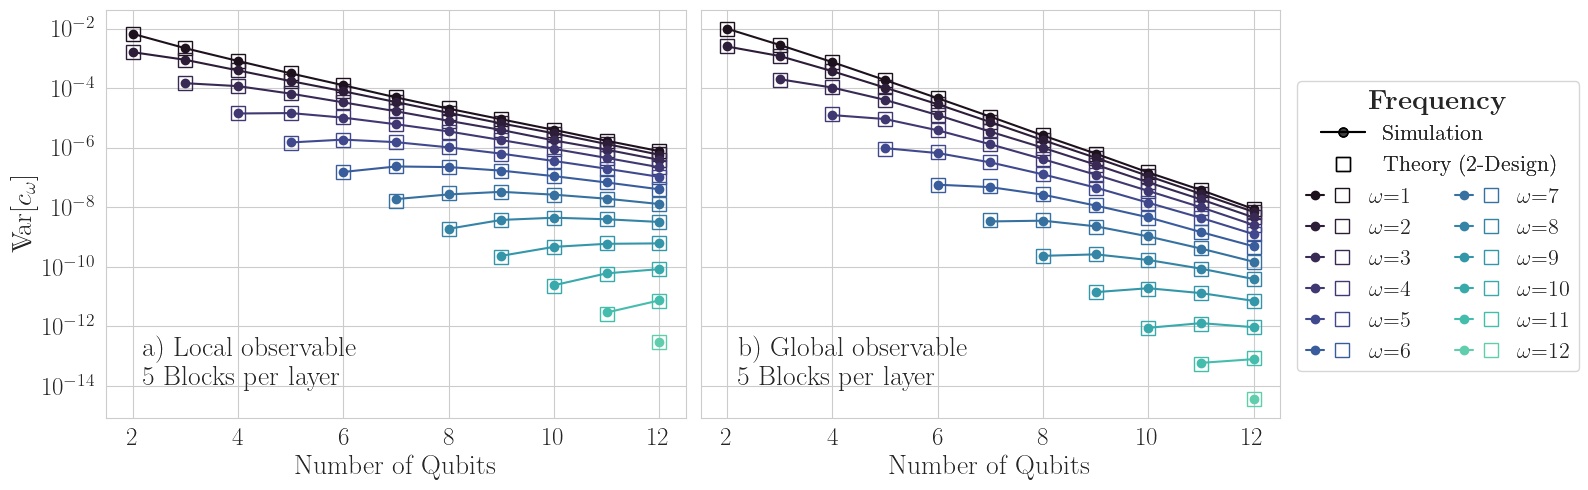

In [32]:
import matplotlib

# matplotlib.use("pgf")
sns.set_style("whitegrid")
matplotlib.rcParams.update(
    {
        "pgf.preamble": (
            r"\usepackage{amsmath} \usepackage{dsfont}  \newcommand{\Var}{\operatorname{\mathds{V}\!ar}}"
        ),
        "pgf.texsystem": "pdflatex",
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
    }
)
matplotlib.rcParams["text.latex.preamble"] = (
    r"\usepackage{amsmath} \usepackage{dsfont}  \newcommand{\Var}{\operatorname{\mathds{V}\!ar}}"
)
plotting_ansatz = "StronglyEntangling"
ax_text = [
    "a) Local observable \n      5 Blocks per layer",
    "b) Global observable \n      5 Blocks per layer",
]
# Define color map based on the ansatz
if plotting_ansatz == "StronglyEntangling":
    colors = sns.color_palette("mako", n_colors=14)
elif plotting_ansatz == "SimplifiedTwoDesign":
    colors = sns.color_palette("rocket", n_colors=15)
else:
    colors = sns.color_palette("YlOrBr_r", n_colors=20)

# Create a 2x2 subplot grid, sharing the x-axis across rows
fig, axs = plt.subplots(1, 2, figsize=(13, 5), sharex=True, sharey=True)

# Initialize empty lists for legend handles
legend_entries = []
legend_handles = []
square_handles = []
unique_sample = mlines.Line2D(
    [],
    [],
    color="k",
    mec=mcolors.to_rgba("k", alpha=1),
    mfc=mcolors.to_rgba("k", alpha=0.5),
    marker="o",
    linestyle="-",
    linewidth=1.5,
    markersize=6.5,
)
unique_theory = mlines.Line2D(
    [], [], color="k", marker="s", linestyle="", markersize=10, markerfacecolor="none"
)
legend_entries.append(unique_sample)
legend_entries.append(unique_theory)

# Plot settings
plot_settings = {"marker": "o", "linewidth": 1.5, "markersize": 6, "zorder": 3}

# Define the range of frequencies to plot
frequency_range = range(1, 13)

# Initialize variables to determine common ylim
min_y, max_y = float("inf"), float("-inf")
i = -1
# Loop for plotting; iterate over rows (layer numbers) and columns (cost types)
for row, plotting_n_layers in enumerate([5]):
    for col, cost_type in enumerate(["local", "global"]):
        ax = axs[col]
        i += 1
        for freq, color in zip(frequency_range, colors):
            # Select the appropriate data based on layer number and cost type
            data_array = var_dataset["var_coeff"].sel(
                encoding="pauli_encoding",
                ansatz=plotting_ansatz,
                freqs=freq,
                n_circuit_layers=1,
                n_layers=plotting_n_layers,
                cost=cost_type,
            )
            theory_array = var_dataset["var_coeff_theory"].sel(
                encoding="pauli_encoding",
                ansatz=plotting_ansatz,
                freqs=freq,
                n_circuit_layers=1,
                n_layers=plotting_n_layers,
                cost=cost_type,
            )

            # Plot the data and theory arrays
            # lines = ax.plot(data_array['n_qubits'], data_array, color=color, **plot_settings)
            # ax.plot(theory_array['n_qubits'], theory_array, color=color, marker='s', linestyle='', markersize=10, markerfacecolor='none')
            # Check if data is above threshold before plotting
            data_above_threshold = data_array.where(data_array > 1e-28, drop=True)
            theory_above_threshold = theory_array.where(theory_array > 1e-28, drop=True)

            if data_above_threshold.size > 0:
                ax.plot(
                    data_above_threshold["n_qubits"],
                    data_above_threshold,
                    color=color,
                    **plot_settings
                )
            if theory_above_threshold.size > 0:
                ax.plot(
                    theory_above_threshold["n_qubits"],
                    theory_above_threshold,
                    color=color,
                    marker="s",
                    linestyle="",
                    markersize=10,
                    markerfacecolor="none",
                )

            # Add legend entries only for the first row and column
            if row == 0 and col == 0:
                legend_handles.append(lines[0])
                square_handles.append(
                    mlines.Line2D(
                        [],
                        [],
                        color=color,
                        marker="s",
                        linestyle="",
                        markersize=10,
                        markerfacecolor="none",
                    )
                )
                line_sample = mlines.Line2D([], [], color=color, **plot_settings)
                legend_entries.append((line_sample, square_handles[-1]))

        # Set axis labels and scale
        if plotting_ansatz == "SimplifiedTwoDesign":
            ax.text(2.2, 10**-14, ax_text[i], fontsize=20)
        else:
            ax.text(2.2, 10**-14, ax_text[i], fontsize=20)
        ax.set_yscale("log")
        ax.tick_params(axis="both", which="major", labelsize=18)
        min_y = min(min_y, ax.get_ylim()[0])
        max_y = max(max_y, ax.get_ylim()[1])
        ax.tick_params(axis="both", which="major", labelsize=18)
        if col == 0:
            ax.set_ylabel(r"$\Var[c_\omega]$", fontsize=20)
        ax.set_xlabel("Number of Qubits", fontsize=20)

# Set the same ylim for all subplots
for ax in axs.flat:
    ax.set_ylim(min_y, max_y)

# Set legends
x_legend_loc, y_legend_loc = 1.227, 0.85
first_legend_labels = ["Simulation", "Theory (2-Design) "]
first_legend = fig.legend(
    [entry for entry in legend_entries[:2]],
    first_legend_labels,
    bbox_to_anchor=(x_legend_loc - 0.01, y_legend_loc - 0.068),
    fontsize=16,
    ncols=1,
    frameon=False,
)

# Add the first legend manually to the plot
empty_handle = mlines.Line2D([], [], color="none", marker="none", linestyle="none")
fig.add_artist(first_legend)
handles = (
    [empty_handle, empty_handle]
    + [entry for entry in legend_entries[2:8]]
    + [empty_handle, empty_handle]
    + [entry for entry in legend_entries[8:]]
)
legend_labels = (
    ["", ""]
    + [r"$\omega$=" + str(freq) for freq in range(1, 7)]
    + ["", ""]
    + [r"$\omega$=" + str(freq) for freq in range(7, 13)]
)
legend = fig.legend(
    handles,
    legend_labels,
    title=r"\textbf{Frequency}",
    bbox_to_anchor=(x_legend_loc, y_legend_loc),
    handler_map={tuple: HandlerTuple(None)},
    title_fontsize=20,
    fontsize=16,
    ncols=2,
)

first_legend.set_zorder(3)
legend.set_zorder(2)

# Adjust the layout
plt.tight_layout()

plt.savefig("figs_numerics/"+plotting_ansatz + "_var_qubits.pgf", bbox_inches="tight")
# Show the plot
plt.show()